# Applying different datasets
This notebook provides a beginner friendly introduction to using different datasets in the context of JATIC and MAITE. So far, we have relied on ART  to load the CIFAR10 dataset. In this notebook, we will show how to load two different datasets (MNIST and hugginface CIFAR) and how to use them within JATIC.

__Intended Audience__: All T&E users

__Requirements__: Basic Python and Torchvision / ML skills

__Time Required__: Full run of the notebook: <1 minute

## Contents
1. Imports
2. Load Satellite classification data
3. Load CIFAR10 model and data from ART
4. Load CIFAR10 from Huggingface
5. Load CIFAR10 from Torchvision
6. Load Single channel dataset from Huggingface (MNIST)
7. Conclusion
8. Next steps

## Take-aways 
- How to load the standard dataset used in the other notebooks (2.)
- Datasets can be imported from many different libraries (3.,4.,5.)
- How to load single channel (black-and-white) image data (6.)

## 1. Imports
We import all necessary libraries for this tutorial. In this order, we first import general libraries such as numpy, then load relevant methods from ART. We then load the corresponding HEART functionality and specific torch functions to support the model. Lastly, we use a command to plot within the notebook.

In [1]:
import numpy as np
import os
import requests
import matplotlib.pyplot as plt

from art.utils import load_dataset 

from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from heart_library.metrics import AccuracyPerturbationMetric

from datasets import load_dataset as load_dataset_hf

import torch
import torchvision
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

%matplotlib inline

## 2. Load Satellite classification data
This way of loading a saetilte dataset is used in all other how-to's.

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

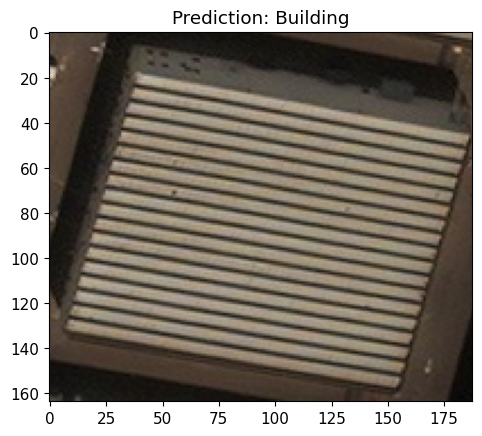

In [2]:
classes = {
    0:'Building',
    1:'Construction Site',
    2:'Engineering Vehicle',
    3:'Fishing Vessel',
    4:'Oil Tanker',
    5:'Vehicle Lot'
}

data = load_dataset_hf("CDAO/xview-subset-classification", split="test[0:12]")
idx = 3
plt.title(f"Prediction: {classes[data[idx]['label']]}")
plt.imshow(data[idx]['image'])

model = torchvision.models.resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(classes.keys())) 
model.load_state_dict(torch.load('../../../utils/resources/models/xview_model.pt'))
_ = model.eval()

## 3. Load CIFAR10 model and data from ART

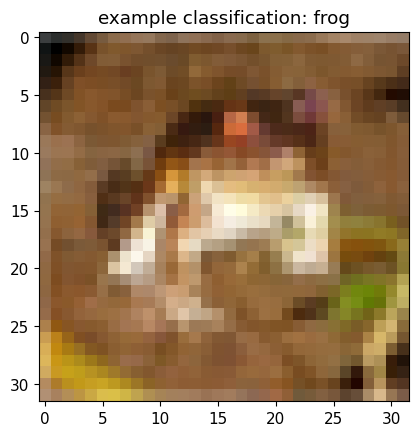

In [4]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
#determine number of used samples
i = 100
#reformat data to fit model
x_train = x_train[:100, :].transpose(0, 3, 1, 2).astype('float32')*255
x_test = x_test[:100, :].transpose(0, 3, 1, 2).astype('float32')*255
y_train = y_train[:100, :].astype('float32')
y_test = y_test[:100, :].astype('float32')

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

path = '../../../'

#model class
class Model(torch.nn.Module):
        """
        Create model for pytorch.
        Here the model does not use maxpooling. Needed for certification tests.
        """

        def __init__(self):
            super(Model, self).__init__()

            self.conv = torch.nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(3, 3)
            )

            self.fullyconnected = torch.nn.Linear(in_features=1600, out_features=10)

            self.relu = torch.nn.ReLU()

            w_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            w_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )

            self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d))
            self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
            self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(w_dense))
            self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

        def forward(self, x):
            """
            Forward function to evaluate the model
            :param x: Input to the model
            :return: Prediction of the model
            """
            x = self.conv(x)
            x = self.relu(x)
            x = x.reshape(-1, 1600)
            x = self.fullyconnected(x)
            x = torch.nn.functional.softmax(x, dim=1)
            return x

# Define the network
model = Model()

# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Get classifier
jptc = JaticPyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=10, clip_values=(0, 255),
    preprocessing=(0.0, 255)
    
)
plt.imshow(x_train[0].transpose(1,2,0).astype(np.uint8))

pred_batch = jptc(x_train[[0]])
_ = plt.title(f'example classification: {labels[np.argmax(np.stack(pred_batch))]}')

## 4. Load CIFAR10 from Huggingface
Alternative way how to load data, which is not based on ART, is to load them from huggingface. Consider that this methods has the same name as the art method, but was here renamed to avoid confusion.

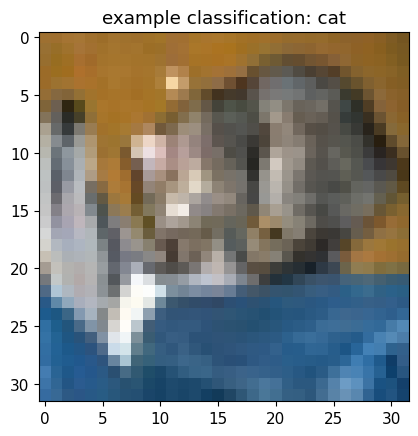

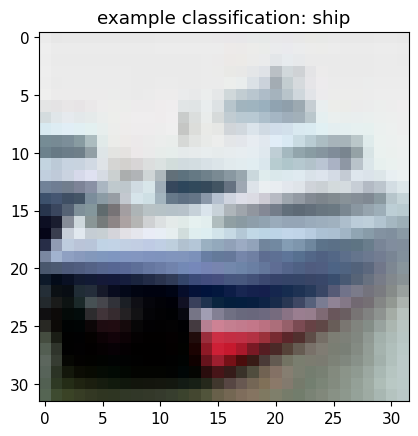

In [5]:
#load the first ten samples of dataset
data = load_dataset_hf("cifar10", split="test[0:10]")

#output performance of previous model on data
pred_batch = jptc(data)
predictions = np.argmax(np.stack(pred_batch), axis=1)
for i, pred in enumerate(predictions[:2]):
    plt.imshow(np.asarray(data.__getitem__(i)['img']))
    plt.title(f'example classification: {labels[pred]}')
    plt.show()

## 5. Load CIFAR10 from Torchvision
Load CIFAR once more, this time using torchvision.

100%|███████████████████████████████████████████████████████████| 170498071/170498071 [00:34<00:00, 4906438.63it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


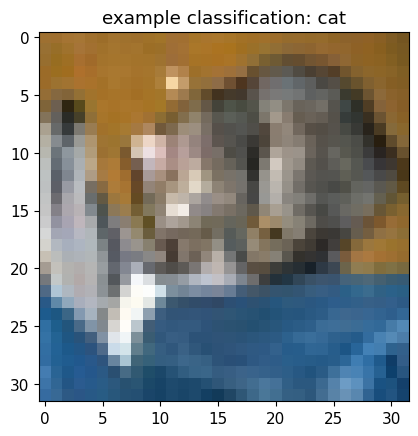

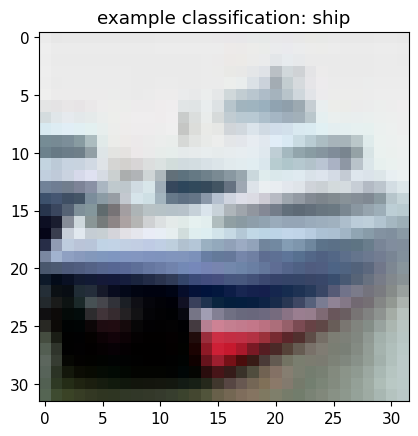

In [6]:
data = torchvision.datasets.CIFAR10("../data", train=False, download=True)
data = torch.utils.data.Subset(data, list(range(10)))

pred_batch = jptc(data)
predictions = np.argmax(np.stack(pred_batch), axis=1)
for i, pred in enumerate(predictions[:2]):
    plt.imshow(np.asarray(data.__getitem__(i)[0]))
    plt.title(f'example classification: {labels[pred]}')
    plt.show()

## 6. Load Single channel dataset from Huggingface (MNIST)

Lastly, we will use the huggingface model once more, but this time load a dataset with a single channel (e.g., black and white).

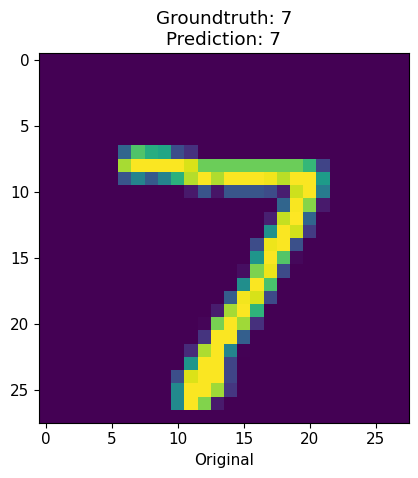

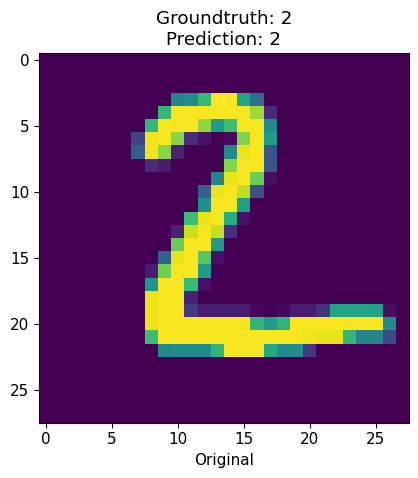

model.safetensors:   0%|          | 0.00/749k [00:00<?, ?B/s]

In [7]:
#simply replace name to load other dataset
data = load_dataset_hf("mnist", split="test[0:10]")
labels = list(range(10))

preprocess = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))

#load a different classifier with high performance on this task
jptc = JaticPyTorchClassifier(
    model='fxmarty/resnet-tiny-mnist', loss=loss_fn, optimizer=optimizer, input_shape=(1, 28, 28), nb_classes=10, clip_values=(0, 1),
    provider="huggingface", preprocessing=([0.45], [0.22]),
)

preds = np.stack(jptc(data))

for i in range(2):
    f, ax = plt.subplots(1,1)
    norm_orig_img = np.asarray(data.__getitem__(i)["image"]).astype(np.float32)

    ax.set_title(f'Groundtruth: {labels[data.__getitem__(i)["label"]]}\nPrediction: {labels[np.argmax(preds[i])]}')
    ax.imshow(norm_orig_img.transpose(1,2,0))
    ax.set_xlabel('Original')


## 7. Conclusion
We have seen how to load different datasets and feed them into the JATIC classifier model. With this tutorial, it should be possible to replace datasets in other how-to's or to load a custom dataset. 

## 8. Next steps
Take a refresher on our previous how-to guides:
- [1. How to Simulate White-box Attacks for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/1_How_to_Simulate_White-box_attacks_for_Image_Classification.ipynb)
- [2. How to Simulate Black-box Attacks for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/2_How_to_Simulate_Black-Box_Attacks_for_Image_Classification.ipynb)
- [3. How to Simulate Auto Attack for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/3_How_to_Simulate_Auto_Attack_for_Image_Classification.ipynb)
- [4. How to Create Defenses for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/4_How_to_Create_Defenses_for_Image_Classification.ipynb)